In [1]:
import networkx as nx
from networkx.algorithms import node_classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\kolpa\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


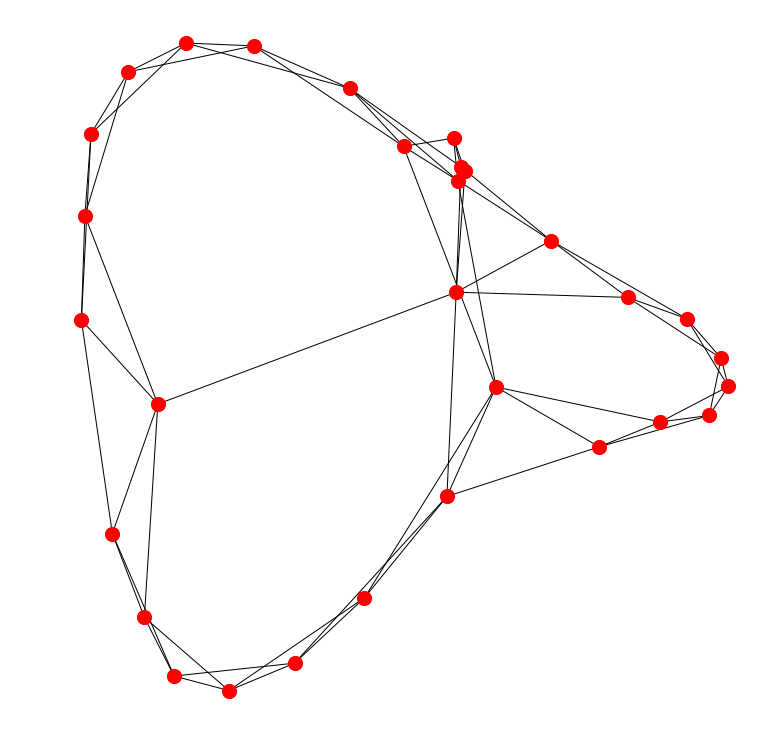

In [2]:
G = nx.generators.newman_watts_strogatz_graph(30,5,0.1337)
gpos = nx.spectral_layout(G, weight=None)
plt.figure(figsize=(10,10))
nx.draw(G, gpos, with_labels=False, node_size=200)
plt.show()

In [3]:
from numpy.random import RandomState

def find_landmarks_sample_inverse(G, num_of_landmarks=3):
    prng = RandomState(42)
    degrees = np.array([val for (node, val) in G.degree()])
    return prng.choice(np.arange(len(degrees)), num_of_landmarks, p=(1./degrees) *1./sum(1./degrees), replace=False )

In [4]:
def noisy_remove(G, p, seed=None):
    prng = RandomState(seed)
    G_copy = G.copy()
    for (a,b) in G.edges():
        if prng.rand() < p and len(G_copy[a])>1 and len(G_copy[b])>1:
            ebunch = [(a,b)]
            G_copy.remove_edges_from(ebunch)
    return G_copy

In [5]:
G1 = noisy_remove(G,0.3)
G2 = noisy_remove(G,0.3)

In [6]:
def visualize_landmarks(G, landmarks):
    labels = {}
    node_colors=[]
    node_sizes=[]
    for i,node in enumerate(G.nodes()):
        node_colors.append('#65abd0')
        node_sizes.append(600)
        if node in landmarks :
            labels[node] = node
        else:
            labels[node] = ''
            node_colors[i] = '#A0CBE2'
            node_sizes[i] = 100
    return (labels, node_colors, node_sizes)

def plot_graphs(G1, G2, landmarks_G1=None, landmarks_G2=None):
    
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.axis('off')
    plt.title('$G_1$')
    pos = nx.spring_layout(G1, weight=None)
    if landmarks_G1 is not None:
        (labels, node_colors, node_sizes) = visualize_landmarks(G1, landmarks_G1)
        nx.draw_networkx_nodes(G1, pos, node_color=node_colors, node_size=node_sizes, font_size=18)
        nx.draw_networkx_labels(G1, pos, font_size=17, labels=labels, font_color = '#262626')
        nx.draw_networkx_edges(G1, pos, width=2, alpha=0.3)
    else:
        nx.draw(G1, gpos, with_labels=False, node_size=100)

    plt.subplot(122)
    plt.axis('off')
    plt.title('$G_2$')
    pos = nx.spring_layout(G2, weight=None)
    if landmarks_G2 is not None:
        (labels, node_colors, node_sizes) = visualize_landmarks(G2, landmarks_G2)
        nx.draw_networkx_nodes(G2, pos, node_color=node_colors, node_size=node_sizes, font_size=18)
        nx.draw_networkx_labels(G2, pos, font_size=17, labels=labels, font_color = '#262626')
        nx.draw_networkx_edges(G2, pos, width=2, alpha=0.3)
    else:
        nx.draw(G2, gpos, with_labels=False, node_size=100)
    

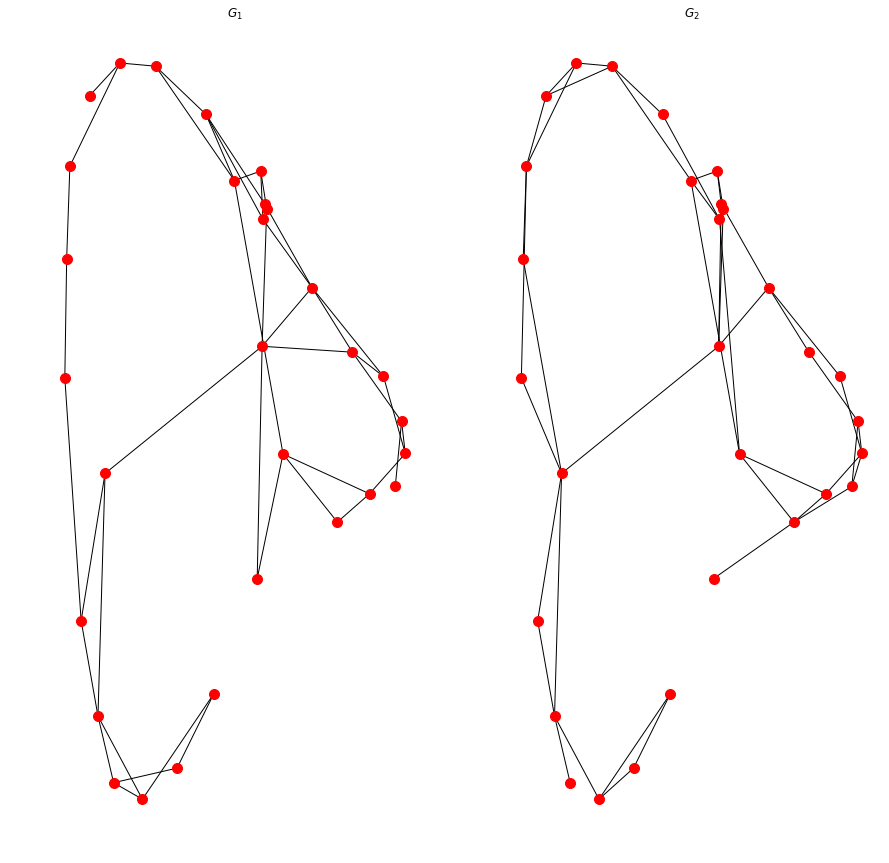

In [7]:
plot_graphs(G1, G2)

In [8]:
landmarks_G1 = find_landmarks_sample_inverse(G1,4)
landmarks_G2 = landmarks_G1

In [9]:
rest_of_nodes = [x for x in G1.nodes() if x not in landmarks_G1]

anonymous_mapping = dict(zip(landmarks_G1,landmarks_G1))
anonymous_mapping.update(zip(rest_of_nodes,np.random.permutation(rest_of_nodes)))
G2 = nx.relabel_nodes(G2,anonymous_mapping, copy=True)

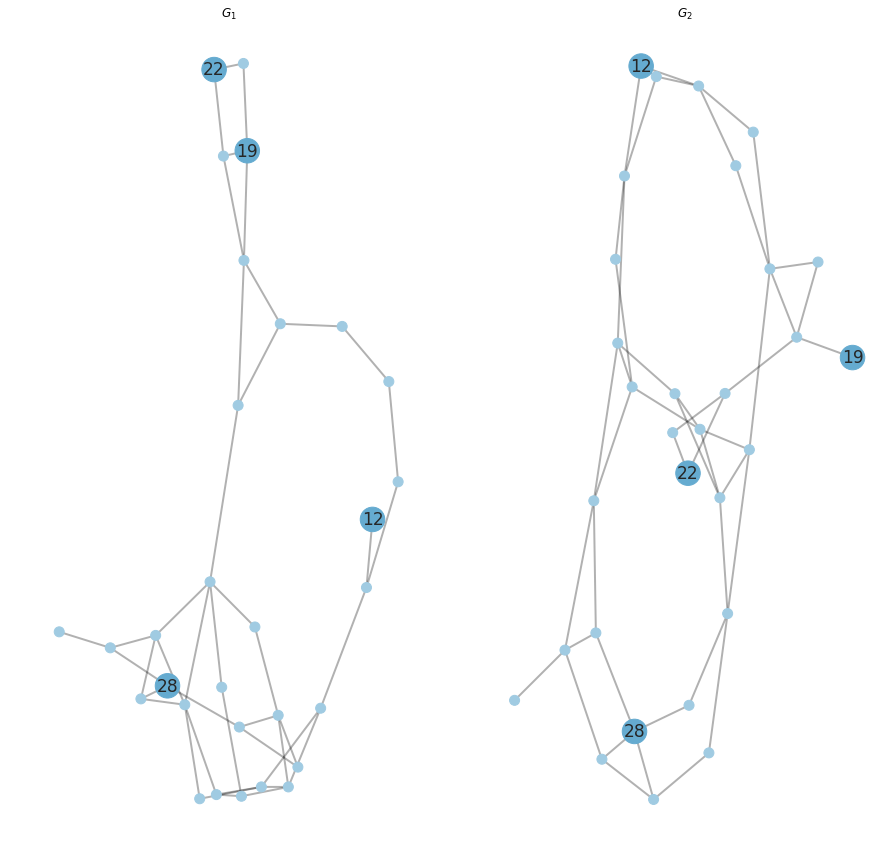

In [10]:
plot_graphs(G1, G2, landmarks_G1, landmarks_G2)

## Shortest-path distance projection
Now that we have picked the landmark sets $L_{G_1}$ and $L_{G_2}$, each of size $l$, and we know the true mapping $\pi_0(i), i \in L_{G_1}$, we will project each node in the graph to a multi-dimensional space.

The projection of node $v$ in $G_i$ is the vector $p(v) \in \mathcal{R}^{l}$ defined as 
\begin{equation} p(v) = \left\lbrace d(v, L_{G_i}^{(1)}), \ldots, d(v, L_{G_i}^{(l)})  \right\rbrace \end{equation}
where $d(v, L_{G_i}^{(j)})$ is the shortest-path distance between node $v$ and the $j$-th landmark. Notice that when we do this projection, the dimensions are ordered according to the mapping between the landmarks. 

In [11]:
def shortest_path_project(G, landmarks):
    projection = np.zeros((G.number_of_nodes() - len(landmarks), len(landmarks)))
    
    for i,landmark in enumerate(landmarks):
        lengths = nx.shortest_path_length(G, source=landmark)
        node_index = 0
        for node in lengths:
            if node in landmarks:
                continue
            projection[node_index][i] = lengths[node]
            node_index += 1           
    return projection

In [12]:
p1 = shortest_path_project(G1,landmarks_G1)
p2 = shortest_path_project(G2,landmarks_G2)

### Projection into 2-dimensional space

In [13]:
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import euclidean_distances

Lets project their coordinates to a $2$-dimensional space by using the **Isomap** algorithm. Keep in mind that the darker the marker is, the bigger the number of points that have the same projection.

In [14]:
def isomap_project(p):
    pairwise_distances = euclidean_distances(p)
    n_samples = p.shape[0]
    noise = np.random.rand(n_samples, n_samples) * 0
    noise = noise + noise.T
    noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
    pairwise_distances += noise
    return Isomap(n_neighbors=10, n_components=2 ).fit_transform(pairwise_distances)

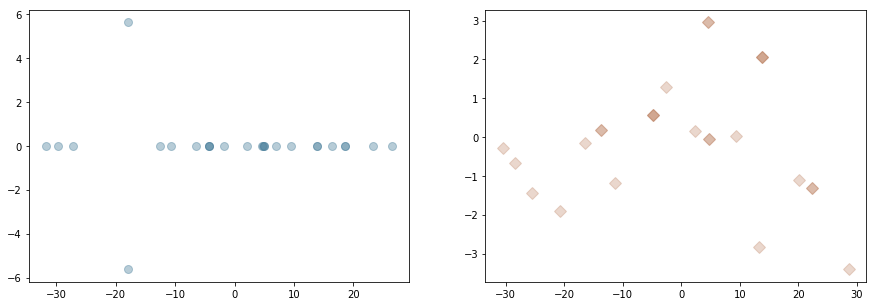

In [15]:
coords1 = isomap_project(p1)
coords2 = isomap_project(p2)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.plot(coords1[:, 0], coords1[:, 1], 'o', alpha = 0.4, markersize=8, c='#4b809c')
ax = plt.subplot(122)
ax.plot(coords2[:, 0], coords2[:, 1], 'D', alpha = 0.3, markersize=8, c='#ba7c5a')

In [16]:
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

class KMeans(BaseEstimator):
 
    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
 
    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                     squared=True).argmin(axis=1)
 
    def _average(self, X):
        return X.mean(axis=0)
 
    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = \
                    self._average(X[center_mask])
 
    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))
 
        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]
 
        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()
 
            self._e_step(X)
            self._m_step(X)
 
            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break
 
        return self
 
class KMedians(KMeans):
 
    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)
 
    def _average(self, X):
        return np.median(X, axis=0)
    
def kmeans_plot(X, mds, ax, n_clusters=8, marker='o'):
    est = KMeans(k=n_clusters)
    est.fit(X-X.mean())
    kmeans_labels = est.labels_
    for k in range(n_clusters):
        my_members = kmeans_labels == k
        ax.plot(mds[my_members, 0], mds[my_members, 1], marker, alpha = 0.6, markersize=8)
    return kmeans_labels

def kmedians_plot(X, mds, ax, n_clusters=8, marker='o'):
    est = KMedians(k=n_clusters)
    est.fit(X-X.mean())
    kmedians_labels = est.labels_
    for k in range(n_clusters):
        my_members = kmedians_labels == k
        ax.plot(mds[my_members, 0], mds[my_members, 1], marker, alpha = 0.6, markersize=8)
    return kmedians_labels

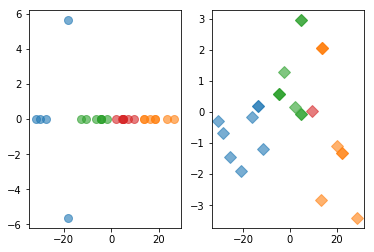

<Figure size 432x288 with 0 Axes>

In [17]:
import brewer2mpl

accent_colors = brewer2mpl.get_map('Accent', 'qualitative',8).mpl_colors
f, (ax1,ax2) = plt.subplots(1,2)
kmeans_labels1 = kmeans_plot(p1, coords1, ax1, n_clusters=4)
plt.figure()
kmeans_labels2 = kmeans_plot(p2, coords2, ax2, n_clusters=4, marker='D')

C:\Users\kolpa\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


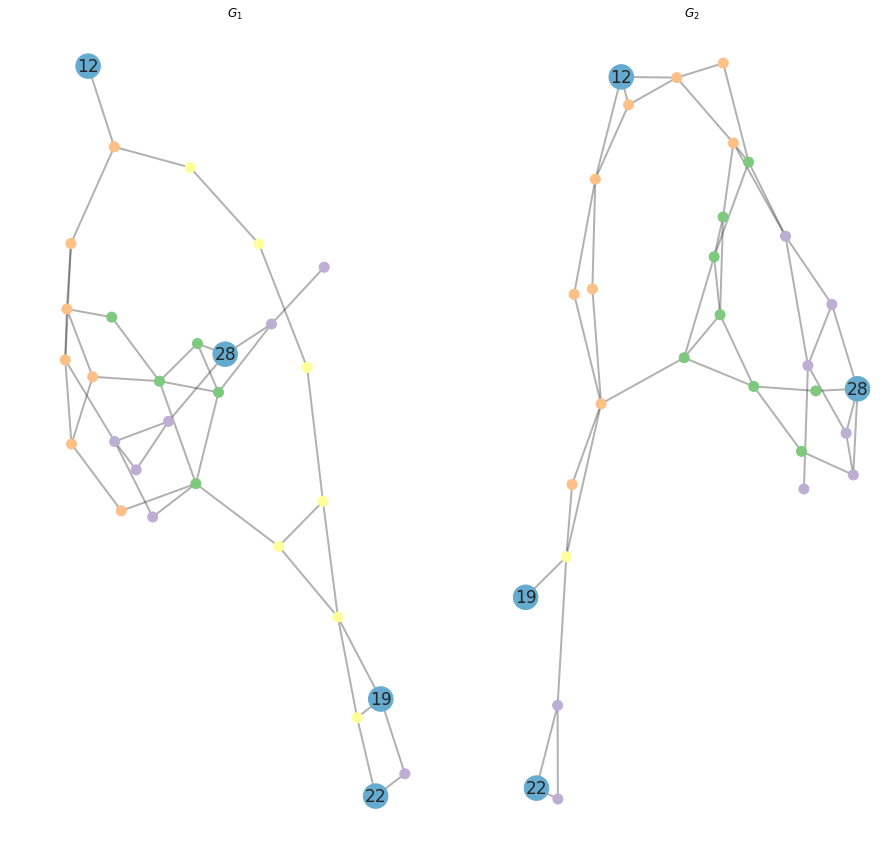

In [18]:
def cluster_colors(G, landmarks, kmeans_labels, colors):
    j=0
    clustered_colors=[]
    for i,node in enumerate(G.nodes()):
        if node not in landmarks:
            clustered_colors.append(colors[kmeans_labels[j]])
            j = j + 1
        else:
            clustered_colors.append((101./256,171./256,208./256))
    return clustered_colors

def paint_clusters(G1, G2, landmarks_G1, landmarks_G2, kmeans_labels1, kmeans_labels2):
    plt.figure(figsize=(15,15))
    accent_colors = brewer2mpl.get_map('Accent', 'qualitative',8).mpl_colors
    plt.subplot(121)
    plt.axis('off')
    plt.title('$G_1$')
    (labels, node_colors, node_sizes) = visualize_landmarks(G1, landmarks_G1)
    clustered_colors = cluster_colors(G1, landmarks_G1, kmeans_labels1, accent_colors)

    pos = nx.spring_layout(G1, weight=None)
    nx.draw_networkx_nodes(G1, pos, node_color=clustered_colors, node_size=node_sizes, font_size=18)
    nx.draw_networkx_labels(G1, pos, font_size=17, labels=labels, font_color = '#262626')
    nx.draw_networkx_edges(G1, pos, width=2, alpha=0.3)

    plt.subplot(122)
    plt.axis('off')
    plt.title('$G_2$')
    (labels, node_colors, node_sizes) = visualize_landmarks(G2, landmarks_G2)
    clustered_colors = cluster_colors(G2, landmarks_G2, kmeans_labels2, accent_colors)

    pos2_init= {key:value for (key, value) in zip(landmarks_G2,[pos[landmark] for landmark in landmarks_G1])}
    pos2 = nx.spring_layout(G2, weight=None, pos = pos2_init)
    nx.draw_networkx_nodes(G2, pos=pos2, node_color=clustered_colors, node_size=node_sizes, font_size=18)
    nx.draw_networkx_labels(G2, pos=pos2, font_size=17, labels=labels, font_color = '#262626')
    nx.draw_networkx_edges(G2, pos=pos2, width=2, alpha=0.3)

paint_clusters(G1,G2,landmarks_G1, landmarks_G2, kmeans_labels1, kmeans_labels2)

### Match nodes from $G_1$ to nodes in $G_2$ by finding the nearest neigbor
To generate a matching, we assign each node from graph $G_1$ to its closest node in graph $G_2$

In [19]:
def find_best_match(pairwise_distances):
    d = np.copy(pairwise_distances)
    matchings=[]
    rows = np.array(np.arange(d.shape[0]))
    cols = np.array(np.arange(d.shape[1]))
    for i in range(d.shape[0]-1):
        s = np.argsort(d, axis=None)
        index = np.unravel_index(s[0],d.shape)
        matchings.append((rows[index[0]], cols[index[1]]))
        d = np.delete(d, index[0],0)
        rows = np.delete(rows, index[0])
        d = np.delete(d, index[1],1)
        cols = np.delete(cols, index[1])
    matchings.append((rows[0], cols[0]))
    return matchings

def print_matching(G, matching_matrix):
    centrality = nx.degree_centrality(G)
    c2 = sorted(centrality, key=centrality.get)
    fig, ax = plt.subplots(1)
    p = ax.pcolormesh(matching_matrix[c2,:][:,c2],cmap=brewer2mpl.get_map('PRGn', 'Diverging',5).mpl_colormap, clim=(-46,46))
    fig.colorbar(p)
    
def count_matches(G1, G2, landmarks_G1, landmarks_G2, best, anonymous_mapping):
    row_labels1 = [i for i in G1.nodes() if i not in landmarks_G1]
    row_labels2 = [i for i in G2.nodes() if i not in landmarks_G2]
    num_points = len(G1.nodes())
    matching_matrix = np.zeros((num_points,num_points))
    atleast_one = False
    correct = 0
    for node in range(len(row_labels1)):
        i = best[node]
        if row_labels2[i] == anonymous_mapping[node]:
            matching_matrix[row_labels2[i]][anonymous_mapping[node]] = 1
            atleast_one = True
            correct += 1
        else:
            matching_matrix[row_labels2[i]][anonymous_mapping[node]] = -1
    for node in landmarks_G1:
        if atleast_one:
            matching_matrix[node][node] = 0.4
        else:
            matching_matrix[node][node] = 1
    return (correct, matching_matrix)

In [20]:
d= euclidean_distances(p1,p2)
best = {k:v for k,v in find_best_match(d)}

In the plot below, we visualize the result of the matching. The x and y axes are the node labels, ordered by the edge centrality of the node. If the cell $(i,j)$ is light green, it means that the node $i \in G_1$ and $j \in G_2$ were used as landmarks. If the cell $(i,j)$ is dark green, it means that the method found a correct matching between nodes $i$ and $j$, in $G_1$ and $G_2$ respectively. Finally, a purple square represents a mismatch. 

Found: 6


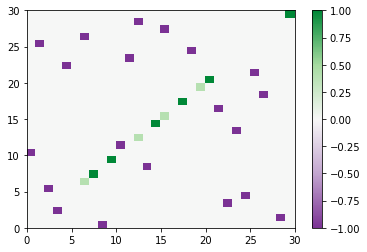

In [21]:
(correct, matching_matrix) = count_matches(G1, G2, landmarks_G1, landmarks_G2, best, anonymous_mapping)
print("Found:", correct)

print_matching(G, matching_matrix)

### Number of landmarks ###
The next thing we will check is how the number of landmarks affects the recovery of nodes. For a fixed graph, and fixed noisy versions of the graph, we try different values of landmark percentage. Every time we repeat the experiment, we pick a different landmark set and measure how many of the node labels we can correctly recover.

In [23]:
best_num = 0
best_found = 0
for landmarks_num in range(1,30):
    
    landmarks_G1 = find_landmarks_sample_inverse(G1, landmarks_num)
    landmarks_G2 = landmarks_G1

    rest_of_nodes = [x for x in G1.nodes() if x not in landmarks_G1]

    anonymous_mapping = dict(zip(landmarks_G1,landmarks_G1))
    anonymous_mapping.update(zip(rest_of_nodes,np.random.permutation(rest_of_nodes)))
    G2 = nx.relabel_nodes(G2,anonymous_mapping, copy=True)

    p1 = shortest_path_project(G1,landmarks_G1)
    p2 = shortest_path_project(G2,landmarks_G2)

    d = euclidean_distances(p1,p2)
    best = {k:v for k,v in find_best_match(d)}

    (correct, matching_matrix) = count_matches(G1, G2, landmarks_G1, landmarks_G2, best, anonymous_mapping)
    
    if correct > best_found:
        best_found = correct
        best_num = landmarks_num
    
    print(f'{landmarks_num} landmarks: {correct} found')
print(f'Best: {best_num} landmarks, {best_found} found')

1 landmarks: 0 found
2 landmarks: 0 found
3 landmarks: 2 found
4 landmarks: 1 found
5 landmarks: 1 found
6 landmarks: 4 found
7 landmarks: 2 found
8 landmarks: 2 found
9 landmarks: 0 found
10 landmarks: 0 found
11 landmarks: 0 found
12 landmarks: 1 found
13 landmarks: 1 found
14 landmarks: 0 found
15 landmarks: 0 found
16 landmarks: 0 found
17 landmarks: 0 found
18 landmarks: 0 found
19 landmarks: 0 found
20 landmarks: 0 found
21 landmarks: 0 found
22 landmarks: 0 found
23 landmarks: 0 found
24 landmarks: 0 found
25 landmarks: 0 found
26 landmarks: 0 found
27 landmarks: 0 found
28 landmarks: 0 found
29 landmarks: 0 found
Best: 6 landmarks, 4 found
